In [1]:
# Импортируем библиотеки

import pandas as pd
import pandahouse as ph
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Определяем функцию для проведения повторяющегося t-теста над p-value
def get_pvalues(df, test_group_1, test_group_2, num_tests):
    p_values = []
    for _ in range(num_tests):
        df_group_2 = df[df.exp_group == test_group_1].sample(n=500)
        df_group_3 = df[df.exp_group == test_group_2].sample(n=500)
        result = stats.ttest_ind(df_group_2.ctr,
                                 df_group_3.ctr,
                                 equal_var=False)
        p_values += [result[1]]
    return pd.DataFrame(p_values, columns=['p_value'])

In [ ]:
Проводим АА-тест для групп 1 и 2 в период с 2023-01-24 по 2023-01-30

In [3]:
# Вытаскиваем данные из clickhouse в pandas с 2023-01-24 по 2023-01-30

connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230220',
              'user':'student', 
              'password':'dpo_python_2020'
              }

query = '''
select exp_group,
       user_id,
       sum(action='like') likes,
       sum(action='view') views,
       likes/views ctr
from {db}.feed_actions 
where toDate(time) >= '2023-01-24' and toDate(time) <= '2023-01-30'
group by exp_group,
       user_id
'''

df_test = ph.read_clickhouse(query, connection=connection)

In [4]:
# Объявляем переменные: контрольная группа, тестовая группа, количество повторений

group_control = 1
group_test = 2
num_tests = 10000

Значение p-values оказалось меньше либо равным 0.05 в 6.96% случаев,
что говорит о том, что наша система сплитования работает некорректно!


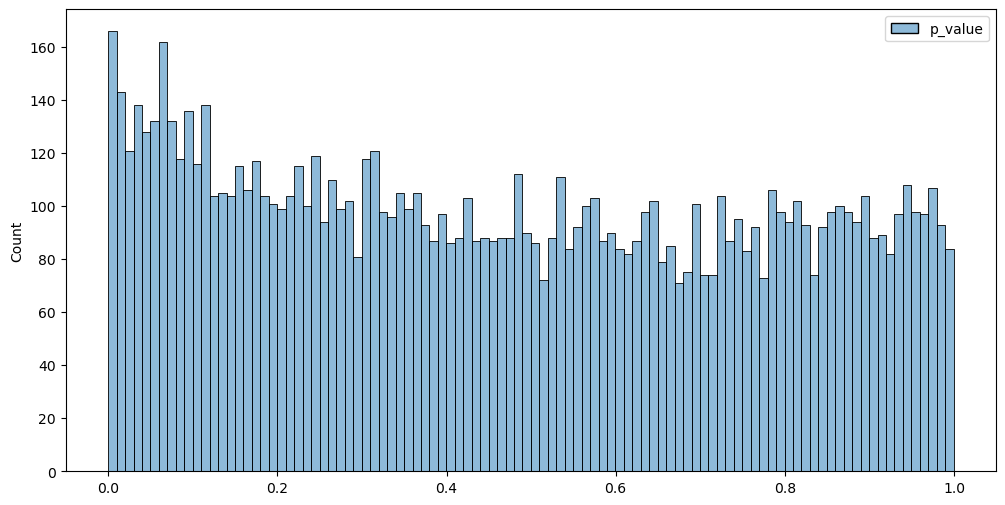

In [5]:
# Делаем выводы

df_pvalues = get_pvalues(df_test, group_control, group_test, num_tests=num_tests)

plt.figure(figsize=(12, 6))
sns.histplot(df_pvalues, bins=100)

percent_pvalue_05 = round(df_pvalues[df_pvalues <= 0.05].count() / num_tests * 100, 2)[0]
answer = 'корректно'

print(f'Значение p-values оказалось меньше либо равным 0.05 в {percent_pvalue_05}% случаев,')
if percent_pvalue_05 > 5:
    answer = 'некорректно'
print(f'что говорит о том, что наша система сплитования работает {answer}!')

In [ ]:
Проводим АB-тест для групп 1 и 2 в период с 2023-01-31 по 2023-02-06

In [6]:
#Вытаскиваем данные из clickhouse в pandas с с 2023-01-31 по 2023-02-06

connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230220',
              'user':'student', 
              'password':'dpo_python_2020'
              }

query = '''
select exp_group,
       user_id,
       sum(action='like') likes,
       sum(action='view') views,
       likes/views ctr
from {db}.feed_actions 
where toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06'
group by exp_group,
       user_id
'''

df_test = ph.read_clickhouse(query, connection=connection)

Значение p-values оказалось меньше либо равным 0.05 в 4.89% случаев,
что говорит о том, что AB-тест показал статитистически значимые различия!


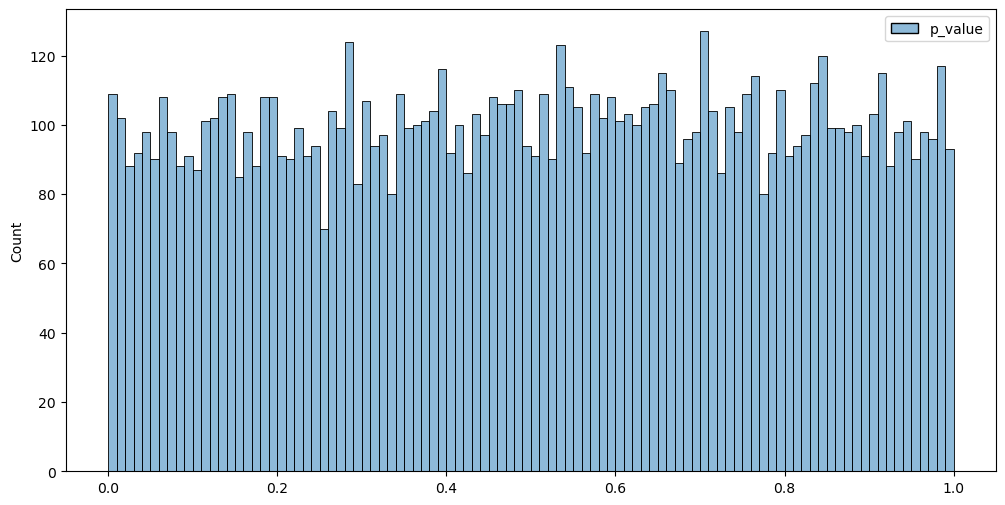

In [10]:
# Делаем выводы

df_pvalues = get_pvalues(df_test, group_control, group_test, num_tests=num_tests)

plt.figure(figsize=(12, 6))
sns.histplot(df_pvalues, bins=100)

percent_pvalue_05 = round(df_pvalues[df_pvalues <= 0.05].count() / num_tests * 100, 2)[0]
answer = 'AB-тест показал статитистически значимые различия'

print(f'Значение p-values оказалось меньше либо равным 0.05 в {percent_pvalue_05}% случаев,')
if percent_pvalue_05 > 5:
    answer = 'AB-тест НЕ показал статитистически значимые различия'
print(f'что говорит о том, что {answer}!')